In [ ]:
from google.colab import drive
import os, zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Path to ZIP and extraction
zip_path = '/content/drive/MyDrive/cleaned_dataset2 (2).zip'
extract_path = '/content/cleaned_dataset2'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm folder path
base_path = os.path.join(extract_path, 'cleaned_dataset2')
if not all(folder in os.listdir(base_path) for folder in ['Train', 'Validate', 'Test']):
    raise Exception("❌ Train/Validate/Test folders missing.")
print("✅ Dataset base path:", base_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset base path: /content/cleaned_dataset2/cleaned_dataset2


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2131 images belonging to 8 classes.
Found 303 images belonging to 8 classes.
Found 616 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,917,960 (11.13 MB)

 Trainable params: 2,186,376 (8.34 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
from collections import Counter
import numpy as np

counter = Counter(train_generator.classes)
max_count = max(counter.values())

class_weights = {i: max_count / count for i, count in counter.items()}
print("✅ Class Weights:", class_weights)


✅ Class Weights: {np.int32(0): 3.005235602094241, np.int32(1): 3.9047619047619047, np.int32(2): 2.079710144927536, np.int32(3): 2.207692307692308, np.int32(4): 2.87, np.int32(5): 3.1538461538461537, np.int32(6): 1.9069767441860466, np.int32(7): 1.0}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_mobilenetv2_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.6851 - loss: 2.1244
Epoch 1: val_accuracy improved from -inf to 0.53135, saving model to /content/drive/MyDrive/best_mobilenetv2_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.6852 - loss: 2.1234 - val_accuracy: 0.5314 - val_loss: 1.4964
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7367 - loss: 1.7166
Epoch 2: val_accuracy improved from 0.53135 to 0.61386, saving model to /content/drive/MyDrive/best_mobilenetv2_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 403ms/step - accuracy: 0.7369 - loss: 1.7163 - val_accuracy: 0.6139 - val_loss: 1.2212
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7506 - loss: 1.5555
Epoch 3: val_accuracy improved from 0.61386 to 0.61716, saving model to /content/drive/MyDrive/best_mobilenetv2_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.7508 - loss: 1.5549 - val_accuracy: 0.6172 - val_loss: 1.2382
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8054 - loss: 1.3242
Epoch 4: val_accuracy did not improve from 0.61716
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.8053 - loss: 1.3243 - val_accuracy: 0.5743 - val_loss: 1.5699
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8298 - loss: 1.1242
Epoch 5: val_accuracy improved from 0.61716 to 0.70297, saving model to /content/drive/MyDrive/best_mobilenetv2_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 410ms/step - accuracy: 0.8297 - loss: 1.1252 - val_accuracy: 0.7030 - val_loss: 1.1353
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8303 - loss: 1.0935
Epoch 6: val_accuracy did not improve from 0.70297
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 378ms/step - accuracy: 0.8303 - loss: 1.0938 - val_accuracy: 0.6832 - val_loss: 1.2590
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8252 - loss: 1.0590
Epoch 7: val_accuracy did not improve from 0.70297
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 377ms/step - accuracy: 0.8254 - loss: 1.0575 - val_accuracy: 0.6832 - val_loss: 1.2076
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8418 - loss: 0.9978
Epoch 8: val_accuracy improved from 0.70297 to 0.73597, saving model to /content/drive/MyDrive/best_mobilenetv2_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.8419 - loss: 0.9975 - val_accuracy: 0.7360 - val_loss: 0.9842
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8898 - loss: 0.7191
Epoch 9: val_accuracy did not improve from 0.73597
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 386ms/step - accuracy: 0.8897 - loss: 0.7200 - val_accuracy: 0.7228 - val_loss: 1.1387
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8633 - loss: 0.8125
Epoch 10: val_accuracy improved from 0.73597 to 0.75908, saving model to /content/drive/MyDrive/best_mobilenetv2_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.8634 - loss: 0.8121 - val_accuracy: 0.7591 - val_loss: 1.0189
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8950 - loss: 0.7204
Epoch 11: val_accuracy did not improve from 0.75908
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 384ms/step - accuracy: 0.8950 - loss: 0.7203 - val_accuracy: 0.7558 - val_loss: 1.0182
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8964 - loss: 0.6596
Epoch 12: val_accuracy did not improve from 0.75908
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 371ms/step - accuracy: 0.8964 - loss: 0.6597 - val_accuracy: 0.7492 - val_loss: 1.1074
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9006 - loss: 0.6168
Epoch 13: val_accuracy improved from 0.75908 to 0.76568, saving model to /content/drive/MyDrive/best_mobilenetv2_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 43s 408ms/step - accuracy: 0.9006 - loss: 0.6170 - val_accuracy: 0.7657 - val_loss: 0.9959


In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6497 - loss: 1.2808
✅ Test Accuracy: 77.11%


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step


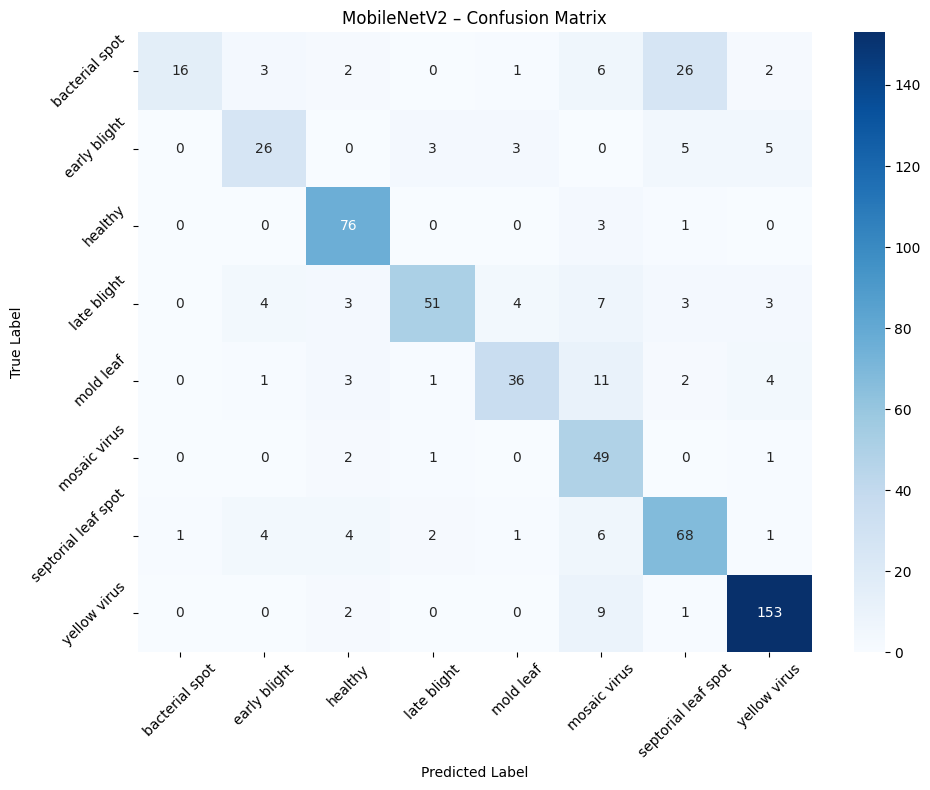

Classification Report:
                     precision    recall  f1-score   support

     bacterial spot       0.94      0.29      0.44        56
       early blight       0.68      0.62      0.65        42
            healthy       0.83      0.95      0.88        80
        late blight       0.88      0.68      0.77        75
          mold leaf       0.80      0.62      0.70        58
       mosaic virus       0.54      0.92      0.68        53
septorial leaf spot       0.64      0.78      0.70        87
       yellow virus       0.91      0.93      0.92       165

           accuracy                           0.77       616
          macro avg       0.78      0.72      0.72       616
       weighted avg       0.80      0.77      0.76       616



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("MobileNetV2 – Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


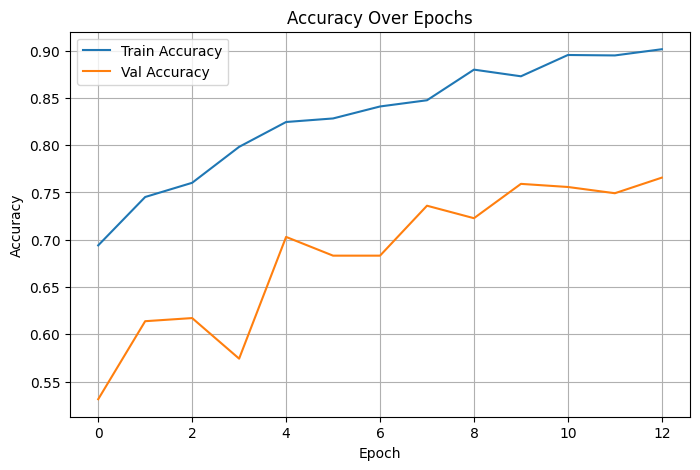

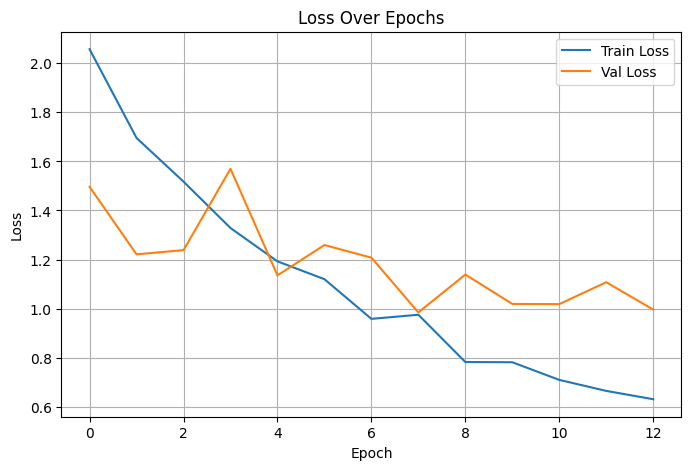

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/mobilenetv2_final_model.keras')
print("✅ Final MobileNetV2 model saved.")


✅ Final MobileNetV2 model saved.
